# Modeling the Affinity of Customers

## Import libraries

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# Scalers
from sklearn.preprocessing import MinMaxScaler

# ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Train/test split
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Oversampling SMOTE
from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

# Classification report
from sklearn.metrics import classification_report

# Model tuning
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis

In [3]:
# Import csv files as pandas dataframe
customer = pd.read_csv("data/rest.csv", sep = ";")
age_and_sex = pd.read_csv("data/alter_geschlecht.csv")
interest = pd.read_csv("data/interesse.csv")

In [4]:
customer.head()

,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,id
0,1,15.0,1,1-2 Year,No,2630.0,124.0,74,317635
1,1,28.0,0,1-2 Year,Yes,2630.0,125.0,213,337993
2,1,33.0,0,1-2 Year,Yes,27204.0,124.0,114,160325
3,1,46.0,1,< 1 Year,No,31999.0,152.0,251,141620
4,1,49.0,0,1-2 Year,Yes,28262.0,26.0,60,75060


In [5]:
age_and_sex.head()

,id,Geschlecht,Alter
0,170727,Male,42
1,41795,Male,24
2,369321,Female,30
3,500463,Female,32
4,327695,Male,34


In [6]:
interest.head()

,id,Interesse
0,1,1.0
1,2,0.0
2,3,1.0
3,4,0.0
4,5,0.0


In [10]:
# Exploring lenght of the tables
print(len(customer))
print(len(age_and_sex))
print(len(interest))

508146
508146
381109


Interest table contains fewer rows than two other tables => In this scenario, we should only keep the rows in the "customer" and "age_and_sex" dataframes that match the IDs in the "interest" dataframe since the "interest" dataframe contains the target variable we want to predict. The rest we can keep for predicting after training the model

In [7]:
# Merge dataframes -> use left join for interest table
data = interest.merge(age_and_sex, on='id', how='left')
data = data.merge(customer, on='id', how='left')
data.head()

,id,Interesse,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue
0,1,1.0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,2,0.0,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
2,3,1.0,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27
3,4,0.0,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
4,5,0.0,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39


In [11]:
# Examine the structure of the table
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               381109 non-null  int64  
 1   Interesse        381109 non-null  float64
 2   Geschlecht       381109 non-null  object 
 3   Alter            381109 non-null  int64  
 4   Fahrerlaubnis    381109 non-null  int64  
 5   Regional_Code    381109 non-null  float64
 6   Vorversicherung  381109 non-null  int64  
 7   Alter_Fzg        381109 non-null  object 
 8   Vorschaden       381109 non-null  object 
 9   Jahresbeitrag    381109 non-null  float64
 10  Vertriebskanal   381109 non-null  float64
 11  Kundentreue      381109 non-null  int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 37.8+ MB
None


In [12]:
# Explore missing values
print(data.isna().sum()) # -> no missing values

id                 0
Interesse          0
Geschlecht         0
Alter              0
Fahrerlaubnis      0
Regional_Code      0
Vorversicherung    0
Alter_Fzg          0
Vorschaden         0
Jahresbeitrag      0
Vertriebskanal     0
Kundentreue        0
dtype: int64


In [13]:
# Explore duplicated rows
print(data.duplicated().sum()) # -> no duplicates

0


In [14]:
# Detecting outliers

# Check categorical features on unexpected values
print(data["Interesse"].unique())
print(data["Geschlecht"].unique())
print(data["Fahrerlaubnis"].unique())
print(data["Vorversicherung"].unique())
print(data["Alter_Fzg"].unique())
print(data["Vorschaden"].unique())

[1. 0.]
['Male' 'Female']
[1 0]
[0 1]
['> 2 Years' '1-2 Year' '< 1 Year']
['Yes' 'No']


In [15]:
# Check values in Regional_Code
np.sort(data['Regional_Code'].unique()) # -> 53 regions

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52.])

In [16]:
# Check values in Vertriebskanal
np.sort(data['Vertriebskanal'].unique()) # -> 163 channels

array([  1.,   2.,   3.,   4.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  73.,  74.,  75.,  76.,  78.,  79.,  80.,
        81.,  82.,  83.,  84.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,
        93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
       104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 114.,
       115., 116., 117., 118., 119., 120., 121., 122., 123., 124., 125.,
       126., 127., 128., 129., 130., 131., 132., 133., 134., 135., 136.,
       137., 138., 139., 140., 143., 144., 145., 146., 147., 148., 149.,
       150., 151., 152., 153., 154., 155., 156., 15

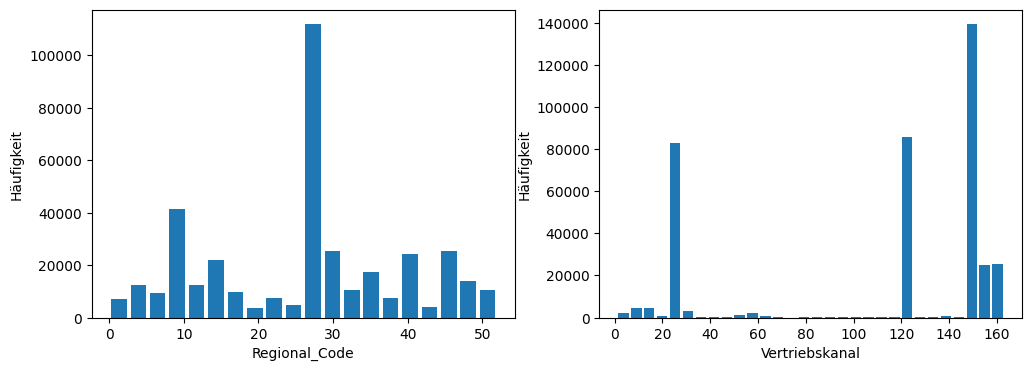

In [17]:
# Check Regional_Code and Vertriebskanal distribution
fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(data['Regional_Code'], bins=20, rwidth=0.8)
plt.xlabel('Regional_Code')
plt.ylabel('Häufigkeit')

plt.subplot(1, 2, 2)
plt.hist(data['Vertriebskanal'], bins=30, rwidth=0.8)
plt.xlabel('Vertriebskanal')
plt.ylabel('Häufigkeit')

plt.show()

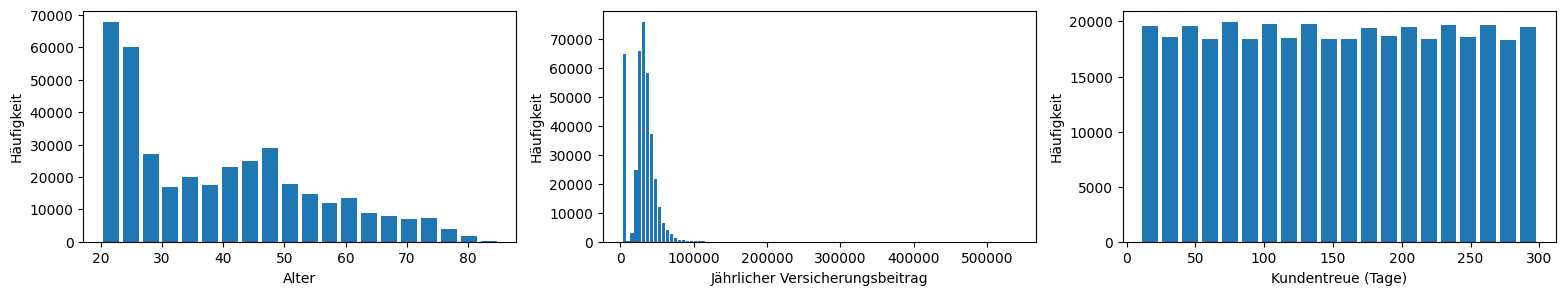

In [80]:
# Check numerical features

fig = plt.figure(figsize=(19,3))

plt.subplot(1, 3, 1)
plt.hist(data['Alter'], bins=20, rwidth=0.8)
plt.xlabel('Alter')
plt.ylabel('Häufigkeit')

plt.subplot(1, 3, 2)
plt.hist(data['Jahresbeitrag'], bins=100, rwidth=0.8)
plt.xlabel('Jährlicher Versicherungsbeitrag')
plt.ylabel('Häufigkeit')

plt.subplot(1, 3, 3)
plt.hist(data['Kundentreue'], bins=20, rwidth=0.8)
plt.xlabel('Kundentreue (Tage)')
plt.ylabel('Häufigkeit')
plt.show()

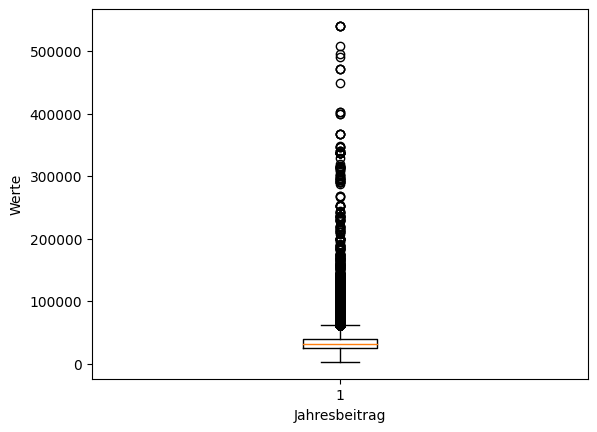

In [81]:
# Plot boxplot of Jahresbeitrag column
plt.boxplot(data['Jahresbeitrag'])
plt.xlabel('Jahresbeitrag')
plt.ylabel('Werte')
plt.show()

There are clearly outliers in Jahresbeitrag column. We can further check it with IQR

In [8]:
# Calculate the quartiles
Q1 = data['Jahresbeitrag'].quantile(0.25)
Q3 = data['Jahresbeitrag'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = data[(data['Jahresbeitrag'] < lower_bound) | (data['Jahresbeitrag'] > upper_bound)]

In [9]:
num_outliers = len(outliers)
num_non_outliers = len(data) - num_outliers
ratio = (num_outliers / len(data)) * 100
print("Percentage of outliers: {:.2f}%".format(ratio))

Percentage of outliers: 2.71%


There are different approaches for dealing with outliers. For now I would just remove outliers. Normally, it is only recommended if the outliers are due to measurement error or other issues and not to actual differences in the data. Since I don't know the nature of outlier and their persentage in the whode data is not so big, I will remove them

In [10]:
# Remove outliers from the main dataframe
data = data[~data['Jahresbeitrag'].isin(outliers['Jahresbeitrag'])]

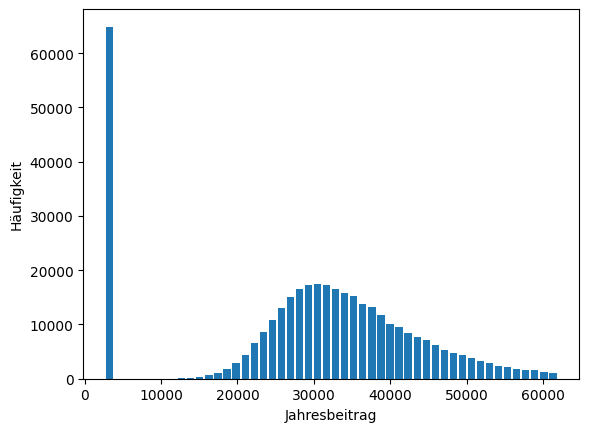

In [15]:
# Check values in Jahresbeitrag after removing outliers
plt.hist(data['Jahresbeitrag'], bins=50, rwidth=0.8)
plt.xlabel('Jahresbeitrag')
plt.ylabel('Häufigkeit')
plt.show()

The data is still not normally distributed. The peak at low values may suggest that the huge proportion of customers has not very expensive annual premium. It might be useful to split the data into two or more groups based on the high peak at low values and the kind of normal distribution at around 30000

Conclusions:
We have 7 categoracal variables: Geschlecht, Fahrerlaubnis, Regional_Code, Vorversicherung, Alter_Fzg, Vorschaden and Vertriebskanal. Some of them need to be encoded:
* Geschlecht -> one-hot-encoding since they don't have ordinal structure
* Alter_Fzg -> ordinal encoder since they have hierarchy (new-middle-old)
* Vorschaden -> label encoder that put 1 if there are previous damages and 0 if not
* Regional_Code and Vertriebskanal -> I cannot use one-hot encoder because it will create too many featurea. Also I cannot use LabelEncoder since some algorithms are sensitive to the ordering of the categories and may assign a higher weight to categories with larger numerical values -> use target encoding

Our numerical values are: Alter, Jahresbeitrag and Kundentreue.

* Jahresbeitrag -> has two peaks -> discretize based on these peaks (low and high annual premium)
* Alter -> it may make sense to discretize Alter column into groups according to car accident statistics (https://www.gdv.de/gdv/themen/mobilitaet/so-wirkt-sich-das-alter-auf-den-kfz-versicherungsbeitrag-aus-12464)
* Kundentreue -> MinMax Scaling

## Feature Engineering and Encoding

In [11]:
# Drop the column "id" since we don't need it anymore
data.drop(columns = ["id"], inplace = True)

In [12]:
# Discretize Jahresbeitrag column

# Threshold value to split the column into two groups
threshold = 7000

# Create a new column to store the group labels
data['Jahresbeitrag_bin'] = "high"
data.loc[data['Jahresbeitrag'] < threshold, 'Jahresbeitrag_bin'] = "low"

# One-hot encoding of Jahresbeitrag_bin column
# Define the mapping from original categorical values to encoded values
ordinal_mapping = {'low': 0, 'high': 1}

# Use the map function to perform the encoding
data['Jahresbeitrag_bin_enc'] = data['Jahresbeitrag_bin'].map(ordinal_mapping)

# Drop the columns which have been encoded
data.drop(columns = ["Jahresbeitrag_bin"], inplace = True)
data.drop(columns = ["Jahresbeitrag"], inplace = True)

In [13]:
# Discretize Alter column
bins = [0, 30, 50, 65, 75, 100]
bin_labels = ['<30', '30-50', '50-65', '65-75', '>75']
data['Alter_binned'] = pd.cut(data['Alter'], bins=bins, labels=bin_labels, right=False)

# One-hot encode the Alter_binned column
data = pd.get_dummies(data, columns=['Alter_binned'])

# Drop Alter column
data.drop(columns = ["Alter"], inplace = True)

In [14]:
# Encoding Regional_Code and Vertriebskanal 

# Import function from utils
from utils.functions import calc_target_encoding

# Apply function to Regional_Code and Vertriebskanal columns
target_mean_regional = calc_target_encoding(data, 'Regional_Code', 'Interesse')
target_mean_channel = calc_target_encoding(data, 'Vertriebskanal', 'Interesse')

# Apply target encoding to the original data
data['Regional_Code_enc'] = data['Regional_Code'].map(target_mean_regional)
data['Vertriebskanal_enc'] = data['Vertriebskanal'].map(target_mean_channel)

# Drop columns which have been encoded
data.drop(columns = ["Regional_Code"], inplace = True)
data.drop(columns = ["Vertriebskanal"], inplace = True)

In [15]:
# Alter_Fzg

# Instantiate the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Define the mapping for each category in the "Alter_Fzg" column
ordinal_mapping = {"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}

# Creating an array that contains the categories of the "Alter_Fzg" column
Alter_Fzg_array = data['Alter_Fzg'].map(lambda x: ordinal_mapping[x]).values.reshape(-1, 1)

# Fit and transform the Alter_Fzg_array to a numerical representation
Alter_Fzg_encoded = ordinal_encoder.fit_transform(Alter_Fzg_array)

# Adding the encoded "Alter_Fzg" column to the original dataframe
data['Alter_Fzg_enc'] = Alter_Fzg_encoded

# Drop the column "Alter_Fzg" which has been encoded
data.drop(columns = ["Alter_Fzg"], inplace = True)

In [16]:
# Geschlecht

# Instantiate the OneHotEncoder
ohe_binary = OneHotEncoder(sparse = False, drop="if_binary") 

# Fit encoder
ohe_binary.fit(data[['Geschlecht']]) 

# Transform the current "Geschlecht" column
data[ohe_binary.get_feature_names_out()] = ohe_binary.transform(data[['Geschlecht']])

# Drop the column "Geschlecht" which has been encoded
data.drop(columns = ["Geschlecht"], inplace = True)

In [17]:
# Vorschaden

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the Vorschaden column
data['Vorschaden'] = le.fit_transform(data['Vorschaden'].values)

In [18]:
data.head()

,Interesse,Fahrerlaubnis,Vorversicherung,Vorschaden,Kundentreue,Jahresbeitrag_bin_enc,Alter_binned_<30,Alter_binned_30-50,Alter_binned_50-65,Alter_binned_65-75,Alter_binned_>75,Regional_Code_enc,Vertriebskanal_enc,Alter_Fzg_enc,Geschlecht_Male
0,1.0,1,0,1,217,1,0,1,0,0,0,0.187526,0.197486,2.0,1.0
1,0.0,1,0,0,183,1,0,0,0,0,1,0.128325,0.197486,1.0,1.0
2,1.0,1,0,1,27,1,0,1,0,0,0,0.187526,0.197486,2.0,1.0
3,0.0,1,1,0,203,1,1,0,0,0,0,0.112988,0.028759,0.0,1.0
4,0.0,1,1,0,39,1,1,0,0,0,0,0.121621,0.028759,0.0,0.0


### Target Classes Balancing

In [19]:
target_count = data['Interesse'].value_counts()
print("Class distribution:")
print(target_count)

Class distribution:
0.0    325634
1.0     45155
Name: Interesse, dtype: int64


In [20]:
# Calculate the ratio of each class
class_ratio = target_count[1] / target_count[0]
print("Ratio of classes:", class_ratio)

Ratio of classes: 0.13866795236369667


In [69]:
# Defining the features and the target
X = data.drop(columns='Interesse')
y = data['Interesse']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((259552, 14), (111237, 14), (259552,), (111237,))

In [70]:
# Create an instance of the SMOTE class
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Fit the SMOTE model to the training data
X_train, y_train = smote.fit_resample(X_train, y_train)

# Fit the SMOTE model to the test data
X_test, y_test = smote.fit_resample(X_test, y_test)

### Scaling

In [23]:
# Scale numerical values: 
num_transformer = Pipeline([('minmax_scaler', MinMaxScaler())])

# Parallelize transformers
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['Kundentreue'])],
    remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_transformer',
                                 Pipeline(steps=[('minmax_scaler',
                                                  MinMaxScaler())]),
                                 ['Kundentreue'])])

In [24]:
# Fit-transform X_train and X_test
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [25]:
# Create a dataframe from transformed tables
norm_data_train = pd.DataFrame(
    X_train_transformed, 
    columns=preprocessor.get_feature_names_out())

norm_data_test = pd.DataFrame(
    X_test_transformed, 
    columns=preprocessor.get_feature_names_out())

## Preliminary Statistical Analysis

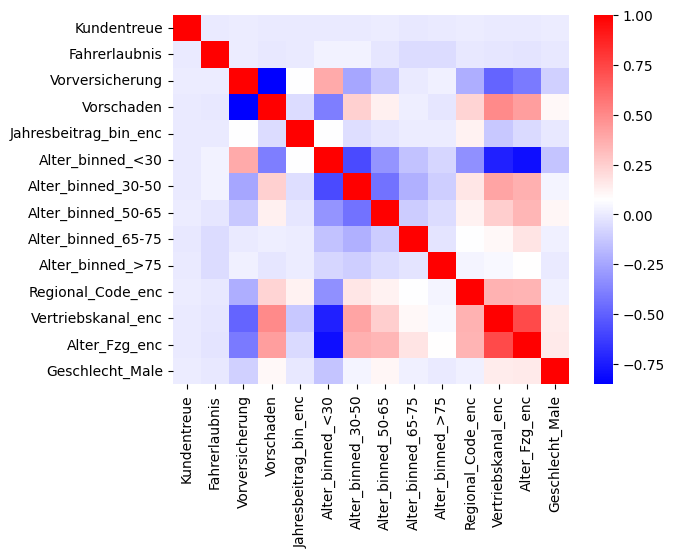

In [55]:
# Heatmap of pairwise correlations
correlation_matrix = norm_data_train.corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr");

In [91]:
# Converting the correlation matrix into a DataFrame
corr_df = correlation_matrix.stack().reset_index()

# Renaming the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

In [92]:
# Computing the absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# Showing the top 5 most correlated pairs of feature
corr_df.sort_values(by="absolute_correlation", ascending=False).head(5*2)

,feature_1,feature_2,correlation,absolute_correlation
82,Alter_binned_<30,Alter_Fzg_enc,-0.831481,0.831481
173,Alter_Fzg_enc,Alter_binned_<30,-0.831481,0.831481
44,Vorschaden,Vorversicherung,-0.823819,0.823819
31,Vorversicherung,Vorschaden,-0.823819,0.823819
179,Alter_Fzg_enc,Vertriebskanal_enc,0.769153,0.769153
166,Vertriebskanal_enc,Alter_Fzg_enc,0.769153,0.769153
81,Alter_binned_<30,Vertriebskanal_enc,-0.731720,0.731720
159,Vertriebskanal_enc,Alter_binned_<30,-0.731720,0.731720
89,Alter_binned_30-50,Alter_binned_<30,-0.604029,0.604029
76,Alter_binned_<30,Alter_binned_30-50,-0.604029,0.604029


## Logistic Regression Modell

Before training the model, we have to choose suitable metrics.

Recall is a better choice since we don't want to miss any positive classes (customers that have interest in offer). We want to reduce false negatives (customers who are interested in offer but were recognized as not-interested). 

We can also use F1 score as a combination of precision and recall

### Pipeline

In [42]:
# Instantiate model
log_reg = LogisticRegression(max_iter=1000, solver='liblinear') 

# Add estimator
pipeline = make_pipeline(preprocessor, log_reg)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Kundentreue'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

In [43]:
# Use recall as the scoring metric
recall_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

# Use precision as the scoring metric
precision_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
mean_precision = precision_scores.mean()
print("Mean precision score:", mean_precision)

# Use precision as the scoring metric
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
mean_f1 = f1_scores.mean()
print("f1 score:", mean_f1)

Mean recall score: 0.9113616558718247
Mean precision score: 0.7481808097601312
f1 score: 0.8217436494260312


## Logistic Model Tuning

### Precision-Recall Tradeoff

In [27]:
df = pd.DataFrame()
df['interest'] = y_train

In [28]:
# Predict class probabilties
df['proba_no_interest'], df['proba_interest'] =cross_val_predict(pipeline,
                                                                X_train,
                                                                df['interest'],
                                                                cv=5,
                                                                method='predict_proba').T

# precision recall data
precision, recall, threshold = precision_recall_curve(df['interest'],
                                                      df['proba_interest']) 

print(f'precision- {precision[:5]}')
print(f'recall- {recall[:5]}')
print(f'threshold- {threshold[:5]}')

precision- [0.5        0.5000011  0.50000219 0.50000329 0.50000439]
recall- [1. 1. 1. 1. 1.]
threshold- [8.77990883e-06 9.08426044e-06 9.16365213e-06 9.55652909e-06
 9.57496516e-06]


In [29]:
scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]}) # Store in a dataframe
scores

,threshold,precision,recall
0,0.000009,0.500000,1.000000
1,0.000009,0.500001,1.000000
2,0.000009,0.500002,1.000000
3,0.000010,0.500003,1.000000
4,0.000010,0.500004,1.000000
...,...,...,...
391873,0.996433,1.000000,0.000022
391874,0.996507,1.000000,0.000018
391875,0.997990,1.000000,0.000013
391876,0.998245,1.000000,0.000009


Text(0.5, 0, 'recall')

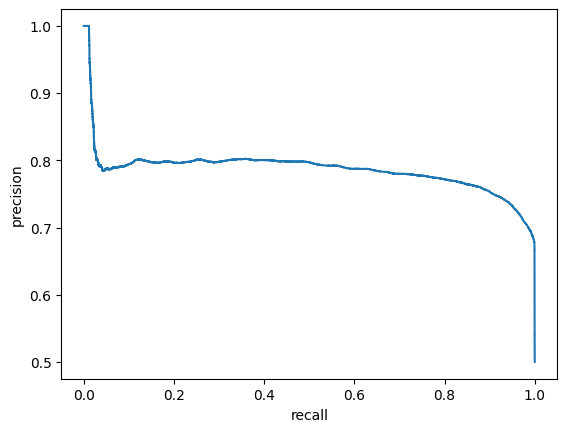

In [30]:
# Plot Precision-Recall Curve
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

In [31]:
# Find suitable threshold
custom_threshold = scores[scores['recall'] >= 0.8].threshold.max()
custom_threshold

0.6696844056527012

In [32]:
# Fit model on train data
pipeline.fit(X_train, y_train)

# Import function for prediction with custom threshold
from utils.functions import custom_predict

# Make predictions
updated_preds = custom_predict(X=X_train, custom_threshold=custom_threshold, pipeline=pipeline) # Update predictions 

print("Recall:", recall_score(df['interest'], updated_preds)) # Rerun recall
print("Precision:", precision_score(df['interest'], updated_preds)) # Rerun precision
print("F1 Score:", f1_score(df['interest'], updated_preds)) # Rerun f1

Recall: 0.8000508954975035
Precision: 0.7716160919442951
F1 Score: 0.7855762706387929


### Feature Permutation and Complexity Reduction

In [35]:
# Fit model
log_model = pipeline.fit(X_train, y_train) 

# Performs Permutation
permutation_score = permutation_importance(log_model, X_train, y_train, n_repeats=10) 

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_train.columns,
                                        permutation_score.importances_mean)).T) 
importance_df.columns=['feature','score decrease']
importance_df['score decrease'] = importance_df['score decrease'].abs()

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False) 

,feature,score decrease
5,Alter_binned_<30,0.096972
2,Vorschaden,0.094007
1,Vorversicherung,0.086404
7,Alter_binned_50-65,0.047875
6,Alter_binned_30-50,0.044888
11,Vertriebskanal_enc,0.030753
8,Alter_binned_65-75,0.017692
9,Alter_binned_>75,0.007654
10,Regional_Code_enc,0.005079
12,Alter_Fzg_enc,0.00097


In [40]:
# Drop the weakest feature
X_train.drop(columns = ["Geschlecht_Male"], inplace = True)
X_train.drop(columns = ["Fahrerlaubnis"], inplace = True)

In [41]:
# Re-instantiate pipeline
log_model = pipeline.fit(X_train, y_train) 

# Cross-validate the model again
recall_scores = cross_val_score(log_model, X_train, y_train, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

precision_scores = cross_val_score(log_model, X_train, y_train, cv=5, scoring='precision')
mean_precision = precision_scores.mean()
print("Mean precision score:", mean_precision)

f1_scores = cross_val_score(log_model, X_train, y_train, cv=5, scoring='precision')
mean_f1 = f1_scores.mean()
print("Mean precision score:", mean_f1)

Mean recall score: 0.911361655679048
Mean precision score: 0.7481645964768121
Mean precision score: 0.7481645964768121


A litte bit better but not significant

### GridSearch

In [47]:
# Instantiate model
log_reg = LogisticRegression(max_iter=1000, solver='liblinear') 

# Add estimator
pipeline = make_pipeline(preprocessor, log_reg)

param_grid = {
    'logisticregression__C': [0.01, 0.05, 0.1, 1],
    'logisticregression__penalty': ['l1', 'l2']
}

f1 = make_scorer(f1_score, greater_is_better=True)
precision = make_scorer(precision_score, greater_is_better=True)
recall = make_scorer(recall_score, greater_is_better=True)

grid = GridSearchCV(pipeline, param_grid=param_grid, scoring={'f1': f1, 'precision': precision, 'recall': recall}, refit='recall', cv=5)
grid.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid.best_params_

print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)

Best parameters:  {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}
Best score:  0.9336485665773393


In [48]:
# Instantiate model
log_reg = LogisticRegression(max_iter=1000, solver='liblinear', penalty = 'l2', C = 0.01) 

# Add estimator
pipeline = make_pipeline(preprocessor, log_reg)

# Use recall as the scoring metric
recall_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

# Use precision as the scoring metric
precision_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
mean_precision = precision_scores.mean()
print("Mean precision score:", mean_precision)

# Use f1 as the scoring metric
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
mean_f1 = f1_scores.mean()
print("Mean f1 score:", mean_f1)

Mean recall score: 0.9336485665773393
Mean precision score: 0.7386978120692552
Mean f1 score: 0.8248025030142598


## Model Evaluation 

In [49]:
# Instantiate model
log_reg = LogisticRegression(max_iter=1000, solver='liblinear', penalty = 'l2', C = 0.01) 

# Add estimator
pipeline = make_pipeline(preprocessor, log_reg)

# Fit model model
pipeline.fit(X_train, y_train) 

# Predict the target classes on the test set
y_pred = pipeline.predict(X_test)

# Calculate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.91      0.67      0.77     97877
         1.0       0.74      0.93      0.82     97877

    accuracy                           0.80    195754
   macro avg       0.82      0.80      0.80    195754
weighted avg       0.82      0.80      0.80    195754



Not perfect results => try some other model

## Random Forest Model

### Initiating

In [50]:
# Instantiate model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Add estimator
pipeline = make_pipeline(preprocessor, random_forest)

# Train the random forest model
pipeline.fit(X_train, y_train)

# Use recall as the scoring metric
recall_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

# Use precision as the scoring metric
precision_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
mean_precision = precision_scores.mean()
print("Mean precision score:", mean_precision)

# Use f1 as the scoring metric
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
mean_f1 = f1_scores.mean()
print("Mean f1 score:", mean_f1)

Mean recall score: 0.894035456129848
Mean precision score: 0.8758836079689123
Mean f1 score: 0.8755175610078842


### Fine-tuning

In [596]:
# Create the classifier
random_forest = RandomForestClassifier()

# Add estimator
pipeline = make_pipeline(preprocessor, random_forest)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [6, 7, 8],
    'max_depth': [9, 10, 11],
    'min_samples_split': [6, 7, 8],
    'min_samples_leaf': [1]
}

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

best_params

{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 8}

In [51]:
best_params = {'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 8}

In [52]:
# Use the best hyperparameters to fit a new classifier
random_forest = RandomForestClassifier(**best_params)

# Add estimator
pipeline = make_pipeline(preprocessor, random_forest)

# Use recall as the scoring metric
recall_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

# Use precision as the scoring metric
precision_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
mean_precision = precision_scores.mean()
print("Mean precision score:", mean_precision)

# Use f1 as the scoring metric
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
mean_f1 = f1_scores.mean()
print("Mean f1 score:", mean_f1)

Mean recall score: 0.9371960970159572
Mean precision score: 0.761943559525824
Mean f1 score: 0.8396480399221211


### Features Permutation

In [56]:
# Use the best hyperparameters to fit a new classifier
random_forest = RandomForestClassifier(**best_params)

# Add estimator
pipeline = make_pipeline(preprocessor, random_forest)

# Fit the model
pipeline.fit(X_train, y_train)

# Performs Permutation
permutation_score = permutation_importance(random_forest, X_train, y_train, n_repeats=10) 

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_train.columns,
                                        permutation_score.importances_mean)).T) 
importance_df.columns=['feature','score decrease']
importance_df['score decrease'] = importance_df['score decrease'].abs()

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False) 

,feature,score decrease
1,Vorschaden,0.208304
0,Vorversicherung,0.064733
4,Alter_binned_<30,0.057916
10,Vertriebskanal_enc,0.045118
11,Alter_Fzg_enc,0.026017
9,Regional_Code_enc,0.021916
5,Alter_binned_30-50,0.012944
6,Alter_binned_50-65,0.009182
7,Alter_binned_65-75,0.003257
8,Alter_binned_>75,0.002996


In [66]:
# Drop the weakest feature
X_train.drop(columns = ["Jahresbeitrag_bin_enc"], inplace = True)
X_train.drop(columns = ["Kundentreue"], inplace = True)

X_test.drop(columns = ["Jahresbeitrag_bin_enc"], inplace = True)
X_test.drop(columns = ["Kundentreue"], inplace = True)

In [65]:
# Use the best hyperparameters to fit a new classifier
random_forest = RandomForestClassifier(**best_params)

# Use recall as the scoring metric
recall_scores = cross_val_score(random_forest, X_train, y_train, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

# Use precision as the scoring metric
precision_scores = cross_val_score(random_forest, X_train, y_train, cv=5, scoring='precision')
mean_precision = precision_scores.mean()
print("Mean precision score:", mean_precision)

# Use f1 as the scoring metric
f1_scores = cross_val_score(random_forest, X_train, y_train, cv=5, scoring='f1')
mean_f1 = f1_scores.mean()
print("Mean f1 score:", mean_f1)

Mean recall score: 0.9440303915325327
Mean precision score: 0.7635229679208726
Mean f1 score: 0.8406539000588544


### Model Evaluation

In [68]:
# Use the best hyperparameters to fit a new classifier
random_forest = RandomForestClassifier(**best_params)

# Fit the model
random_forest.fit(X_train, y_train)

# Predict the target classes on the test set
y_pred = random_forest.predict(X_test)

# Calculate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.92      0.72      0.81     97939
         1.0       0.77      0.94      0.85     97939

    accuracy                           0.83    195878
   macro avg       0.85      0.83      0.83    195878
weighted avg       0.85      0.83      0.83    195878



## SDGClassifier

### Instantiating model

In [71]:
# Instantiate model
sgd_clf = SGDClassifier()

# Add estimator
pipeline = make_pipeline(preprocessor, sgd_clf)

# Fit the model
pipeline.fit(X_train, y_train)

# Use recall as the scoring metric
recall_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

# Use precision as the scoring metric
precision_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
mean_precision = precision_scores.mean()
print("Mean precision score:", mean_precision)

# Use f1 as the scoring metric
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
mean_f1 = f1_scores.mean()
print("Mean f1 score:", mean_f1)

Mean recall score: 0.9722585171219362
Mean precision score: 0.7095158531507962
Mean f1 score: 0.8203627522369296


### Fine-Tuning

In [75]:
# Create the classifier
sgd_clf = SGDClassifier()

# Add estimator
pipeline = make_pipeline(preprocessor, sgd_clf)

# Define the parameter grid to search over
param_grid = {
    'sgdclassifier__loss': ['hinge', 'log', 'perceptron'],
    'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'],
    'sgdclassifier__alpha': [0.0001, 0.001, 0.01, 0.1]
}

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_params


{'sgdclassifier__alpha': 0.1,
 'sgdclassifier__loss': 'hinge',
 'sgdclassifier__penalty': 'l1'}

In [76]:
# Define the parameter grid to search over
param_grid = {
    'sgdclassifier__loss': ['hinge', 'log', 'perceptron'],
    'sgdclassifier__penalty': ['l2', 'l1', 'elasticnet'],
    'sgdclassifier__alpha': [0.05, 0.1, 0.2, 0.3, 0.4, 0.6]
}

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_params

{'sgdclassifier__alpha': 0.2,
 'sgdclassifier__loss': 'hinge',
 'sgdclassifier__penalty': 'l2'}

In [80]:
# Create the classifier
sgd_clf = SGDClassifier(alpha = 0.2)

# Add estimator
pipeline = make_pipeline(preprocessor, sgd_clf)

# Fit the model
pipeline.fit(X_train, y_train)

# Use recall as the scoring metric
recall_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

# Use precision as the scoring metric
precision_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
mean_precision = precision_scores.mean()
print("Mean precision score:", mean_precision)

# Use f1 as the scoring metric
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
mean_f1 = f1_scores.mean()
print("Mean f1 score:", mean_f1)

Mean recall score: 0.9904853772964441
Mean precision score: 0.6809473568506368
Mean f1 score: 0.807064139349991


### Model evaluation

In [82]:
# Create the classifier
sgd_clf = SGDClassifier(alpha = 0.2)

# Add estimator
pipeline = make_pipeline(preprocessor, sgd_clf)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict the target classes on the test set
y_pred = pipeline.predict(X_test)

# Calculate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.54      0.70     97564
         1.0       0.68      0.99      0.81     97564

    accuracy                           0.77    195128
   macro avg       0.83      0.77      0.75    195128
weighted avg       0.83      0.77      0.75    195128



In [83]:
# Performs Permutation
permutation_score = permutation_importance(pipeline, X_train, y_train, n_repeats=10) 

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_train.columns,
                                        permutation_score.importances_mean)).T) 
importance_df.columns=['feature','score decrease']
importance_df['score decrease'] = importance_df['score decrease'].abs()

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False) 

,feature,score decrease
2,Vorschaden,0.078304
1,Vorversicherung,0.076965
5,Alter_binned_<30,0.002054
12,Alter_Fzg_enc,0.001224
6,Alter_binned_30-50,0.000396
7,Alter_binned_50-65,0.00011
8,Alter_binned_65-75,0.00003
9,Alter_binned_>75,0.000022
0,Fahrerlaubnis,0.000006
11,Vertriebskanal_enc,0.000005


In [98]:
# Drop the weakest feature
X_train.drop(columns = ["Geschlecht_Male"], inplace = True)
X_train.drop(columns = ["Regional_Code_enc"], inplace = True)
X_train.drop(columns = ["Jahresbeitrag_bin_enc"], inplace = True)
X_train.drop(columns = ["Kundentreue"], inplace = True)

X_test.drop(columns = ["Geschlecht_Male"], inplace = True)
X_test.drop(columns = ["Regional_Code_enc"], inplace = True)
X_test.drop(columns = ["Jahresbeitrag_bin_enc"], inplace = True)
X_test.drop(columns = ["Kundentreue"], inplace = True)

In [99]:
# Create the classifier
sgd_clf = SGDClassifier(alpha = 0.2)

# Fit the model
sgd_clf.fit(X_train, y_train)

# Use recall as the scoring metric
recall_scores = cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring='recall')
mean_recall = recall_scores.mean()
print("Mean recall score:", mean_recall)

# Use precision as the scoring metric
precision_scores = cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring='precision')
mean_precision = precision_scores.mean()
print("Mean precision score:", mean_precision)

# Use f1 as the scoring metric
f1_scores = cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring='f1')
mean_f1 = f1_scores.mean()
print("Mean f1 score:", mean_f1)

Mean recall score: 0.9904853772964441
Mean precision score: 0.6809566486581822
Mean f1 score: 0.8070554824792311


In [100]:
# Fit the model
sgd_clf.fit(X_train, y_train)

# Predict the target classes on the test set
y_pred = sgd_clf.predict(X_test)

# Calculate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.54      0.70     97564
         1.0       0.68      0.99      0.81     97564

    accuracy                           0.77    195128
   macro avg       0.83      0.77      0.75    195128
weighted avg       0.83      0.77      0.75    195128



In [ ]:
# Create the classifier
svc = SVC()

# Define the parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': [0.1, 0.01, 0.001, 'scale', 'auto']
}

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params
